<a href="https://colab.research.google.com/github/AndreisPurim/STONE_challenge/blob/main/Stone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solution to STONE's Data Intern Challenge

**Name:** Andreis Gustavo Malta Purim

Hello, this is my solution to STONE's Data Intern Challenge. Since the Challenge is written in English, all commentaries in this solution will be as well.

The decision to use a google collab notebook was based on the idea that Python is powerful and easy to use, and using a notebook allows me to show graphs easily. I tried my best to separate and comment, but I expect some functions to be too condensed for a clean-reading.

If you have any questions, feel free to ask me.

First, let's start importing some libraries that we'll use.

In [123]:
# Install the psycopg2 library to acess PostgreSQL databases
!pip install psycopg2

# Import libraries
from IPython.display import Markdown, display
from IPython.display import clear_output
import matplotlib.pyplot as matplotlib
from collections import Counter
import psycopg2
import seaborn
import pandas
import numpy

# IPython-based function to print in Markdown style.
def printmd(string):
    display(Markdown(string))

# Clears library import text.
clear_output()

Now, let's acess STONE's PostgreSQL database. The idea is to make a function that can acess a generic database and return the connection if it worked. Also it is useful to say what type of server we connected.

In [49]:
# A function to acess the databse using psycopg2. The 'str' indicators just a personal prefence to be clear what type of objects are we using in the function.
def acessDatabase(dbname: str, user: str, password: str, host: str, port: str):
  '''Input: acess data to PostgreSQL database. Output: connection object if sucessful, otherwise is False'''
  try:
    # Connects to server.
    connection = psycopg2.connect(
      dbname = dbname,
      user = user,
      password = password,
      host = host,
      port = port
    )
    # Says what type of server are we running. Prints in Markdown fashion
    cur = connection.cursor()
    cur.execute('SELECT version()')
    printmd("**Connected!** " + cur.fetchone()[0])
    return connection
  except:
    printmd("**Failed to connect** to _" + dbname + "_ database at _" + host + "_")
    return False

connection = acessDatabase("postgres", "read_only_user", "banking123", "db-stone.cjepwwjnksng.us-east-1.rds.amazonaws.com", "5432")

**Connected!** PostgreSQL 11.8 on x86_64-pc-linux-gnu, compiled by gcc (GCC) 4.8.3 20140911 (Red Hat 4.8.3-9), 64-bit

Now that we are connected, let's use the connection to extract all tables from the database and organize them in panda dataframes. This generic function is done in a way that no matter what type of table or name is inside the server, we can acess it and use a dictionary to get the values.

In [53]:
def acessTables(connection):
  '''Input: connection object. Output: Dictionary with pandas dataframe for every table in server.'''
  # Checks if connection is valid
  if connection:

    # Selects all tables
    cur = connection.cursor()  
    cur.execute("""SELECT table_name FROM information_schema.tables WHERE table_schema = 'public'""")
    tables = [table[0] for table in cur.fetchall()]
    printmd("Tables available: [ _" + "_, _".join(tables) + "_ ]")

    # Makes a dictionary of 'name' and empty dictionary.
    dataframes = {table: {} for table in tables}

    for table in tables:
      # Selects table, uses the description as column name, rows as values
      cur.execute("Select * FROM " + table)
      colnames = [desc[0] for desc in cur.description]
      rows = cur.fetchall()
      # Adds row and index 0, 1... N of every value
      pand = {i: row for i,row in enumerate(rows)}
      dataframes[table] = pandas.DataFrame.from_dict(pand, orient='index', columns = colnames)
    return dataframes
  else:
    printmd("Connection is **not valid.** Check if access function returned a valid result.")
    return False

# Since data is a dictionary of panda dataframes, you just need to add the name of the table you want to acess. This is generic enough that if the server has new tables this function does not need to be redone.
data = acessTables(connection)
data['cards']

Tables available: [ _customers_, _cards_, _transactions_, _frauds_ ]

,card_number,card_family,credit_limit,customer_id
0,8638-5407-3631-8196,Premium,530000,CC67088
1,7106-4239-7093-1515,Gold,18000,CC12076
2,6492-5655-8241-3530,Premium,596000,CC97173
3,2868-5606-5152-5706,Gold,27000,CC55858
4,1438-6906-2509-8219,Platinum,142000,CC90518
...,...,...,...,...
495,4708-4407-9601-6022,Premium,691000,CC64993
496,6042-2856-7280-2925,Gold,33000,CC26787
497,8706-3809-5167-3899,Premium,144000,CC32532
498,9540-8558-5897-5046,Premium,830000,CC90246


Now, let's answer the first 3 questions.

* What is the average ```age``` of the customers in the database? _The average age is 35.1 years old_

* How is the ```card_family``` ranked based on the ```credit_limit``` given to each card? _Gold has a range of 2000-50000. Platinum has a range of 51000-200000. Premium has a range of 108000-899000._

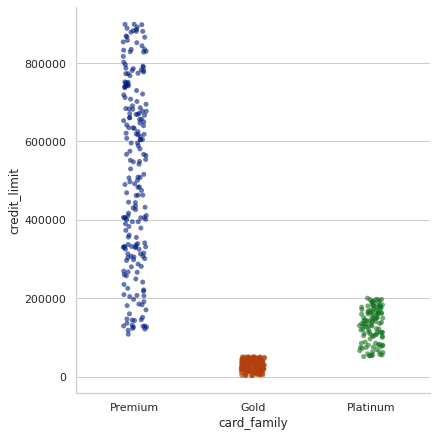

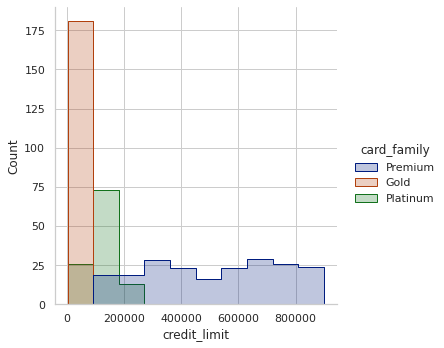

* For the transactions flagged as fraud, what are the ids of the transactions with the highest value? _The 5 most frequent are [CTID99663510, CTID99066676, CTID98722314, CTID97776833, CTID97760025]_

,transaction_id
0,99663510
1,99066676
2,98722314
3,97776833
4,97760025
5,96772424
6,95884307
7,95859840
8,95135812
9,94511089


In [144]:
def answerQuestions(data: dict) -> pandas.DataFrame:
  '''Function to answer the three questions of the challenge. Returns a pandas dataset to be colored'''
  # The first question, we only need to acess the 'customers' dataframe, and use .mean() in the 'age' series
  printmd("* What is the average ```age``` of the customers in the database? _The average age is " + str(round(data['customers']['age'].mean(),1)) + " years old_")

  # The second question can be quickly answered looking at the graph below, but I will also write the ranges
  families = ['Gold','Platinum','Premium']
  # Finds every family in the cards table and extracts credit_limit.
  ranges = [data['cards'][data['cards']['card_family'] == family]['credit_limit'] for family in families]
  # Makes a list with the range of all families
  ranges = [family + " has a range of " + str(min(range))+"-"+str(max(range)) for range,family in zip(ranges,families)]
  printmd("* How is the ```card_family``` ranked based on the ```credit_limit``` given to each card? _" + ". ".join(ranges) + "._")
  # Makes a small EDA dataframe to plot in seaborn.
  EDA = data['cards'][['card_family','credit_limit']]
  EDAby = EDA.groupby('card_family').describe()
  seaborn.set_theme(style="whitegrid")
  # First a catplot to show each individual point. I personally find this easier to visualize
  seaborn.catplot(x='card_family', y='credit_limit', data=EDA, hue='card_family', ci="sd", palette="dark", alpha=.6, height=6)
  matplotlib.show()
  # A distplot just to show (again) the distribution per credit
  seaborn.displot(EDA, x="credit_limit",hue='card_family',palette="dark", element="step")
  matplotlib.show()

  # For question 3, we just need to sort the fraud data. I added a fraud_flag == True just to be sure.
  # I know the frauds table has only True values but I think it is professional to verify it again, in case someone accidentaly added a non-fraud ID.
  ids = data['frauds'][data['frauds']['fraud_flag'] == True].sort_values('transaction_id',ascending=False)
  printmd("* For the transactions flagged as fraud, what are the ids of the transactions with the highest value? _The 5 most frequent are ["+ ", ".join(ids['transaction_id'][:5]) + "]_")
  # If you remove CTID from the beggining of the strings, we can style it nicely.
  ids['transaction_id'] = ids['transaction_id'].apply(lambda x: int(x.strip("CTID")))
  return ids.drop('fraud_flag',axis=1).reset_index(drop=True)[:20]

# This weird function call is to format the Dataframe that comes from the return.
answerQuestions(data).style.background_gradient(cmap='Greens', subset='transaction_id')

# Analysis

Now, let's analyze whether or not the fraudulent transactions are somehow associated to the other features of the dataset.

My initial hunch was to merge the values of all tables with fraud and utilize a pairplot to see every feature. This was the initial idea:

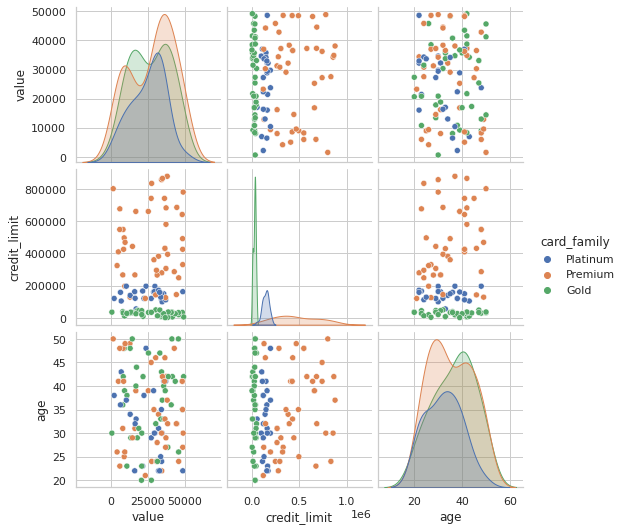

,id,card_number,transaction_date,value,segment_x,card_family,credit_limit,customer_id,age,segment_y,vintage_group
0,CTID50558449,4246-1369-3659-8804,2016-05-06,6984,SEG23,Platinum,105000,CC21111,43,Platinum,VG2
1,CTID55936882,1336-9200-1264-2551,2016-11-29,34367,SEG21,Premium,280000,CC16420,22,Gold,VG3
2,CTID63762180,8528-6154-7390-5081,2016-12-05,44550,SEG15,Premium,686000,CC90833,32,Diamond,VG1
3,CTID76723439,7908-2695-7391-7499,2016-09-15,48275,SEG16,Gold,34000,CC53797,35,Diamond,VG1
4,CTID21246201,2524-4184-5908-6750,2016-02-29,35751,SEG25,Platinum,150000,CC69171,41,Diamond,VG1
...,...,...,...,...,...,...,...,...,...,...,...
104,CTID15034243,4562-2665-7578-1931,2016-02-14,48845,SEG19,Premium,781000,CC19186,30,Diamond,VG1
105,CTID99663510,8783-7271-8493-7931,2016-01-18,6044,SEG17,Premium,677000,CC39128,23,Gold,VG3
106,CTID57993591,6697-9358-9213-4896,2016-04-02,31486,SEG24,Gold,13000,CC89895,24,Diamond,VG1
107,CTID91108283,9207-1270-6690-4905,2016-07-17,36706,SEG11,Gold,2000,CC65624,39,Gold,VG3


In [204]:
def analysis1(data: dict) -> pandas.DataFrame:
  '''Receives the dataset, merges and makes a pairplot.'''
  # To merge correctly, some columns have to renamed.
  df1 = pandas.merge(data['frauds'].rename(columns={'transaction_id':'id'}), data['transactions'], on=['id'])
  df2 = pandas.merge(df1, data['cards'], on=['card_number'])
  df3 = pandas.merge(df2, data['customers'].rename(columns={'id':'customer_id'}), on=['customer_id'])
  # Drops fraud flag, since it's not useful anymore
  df4 = df3[df3['fraud_flag'] == True].drop(['fraud_flag'], axis=1)
  # Plots pairplot
  seaborn.pairplot(df4, hue="card_family")
  matplotlib.show()
  # Returns dataframe for it to appear in the notebook display.
  return df4

frauds_merged = analysis1(data)
frauds_merged

As you can see, we have a few problems: First, not all columns were used in the pairplot because they are str instead of numerical. Second, this was not very telling. Let's try to solve this problem:

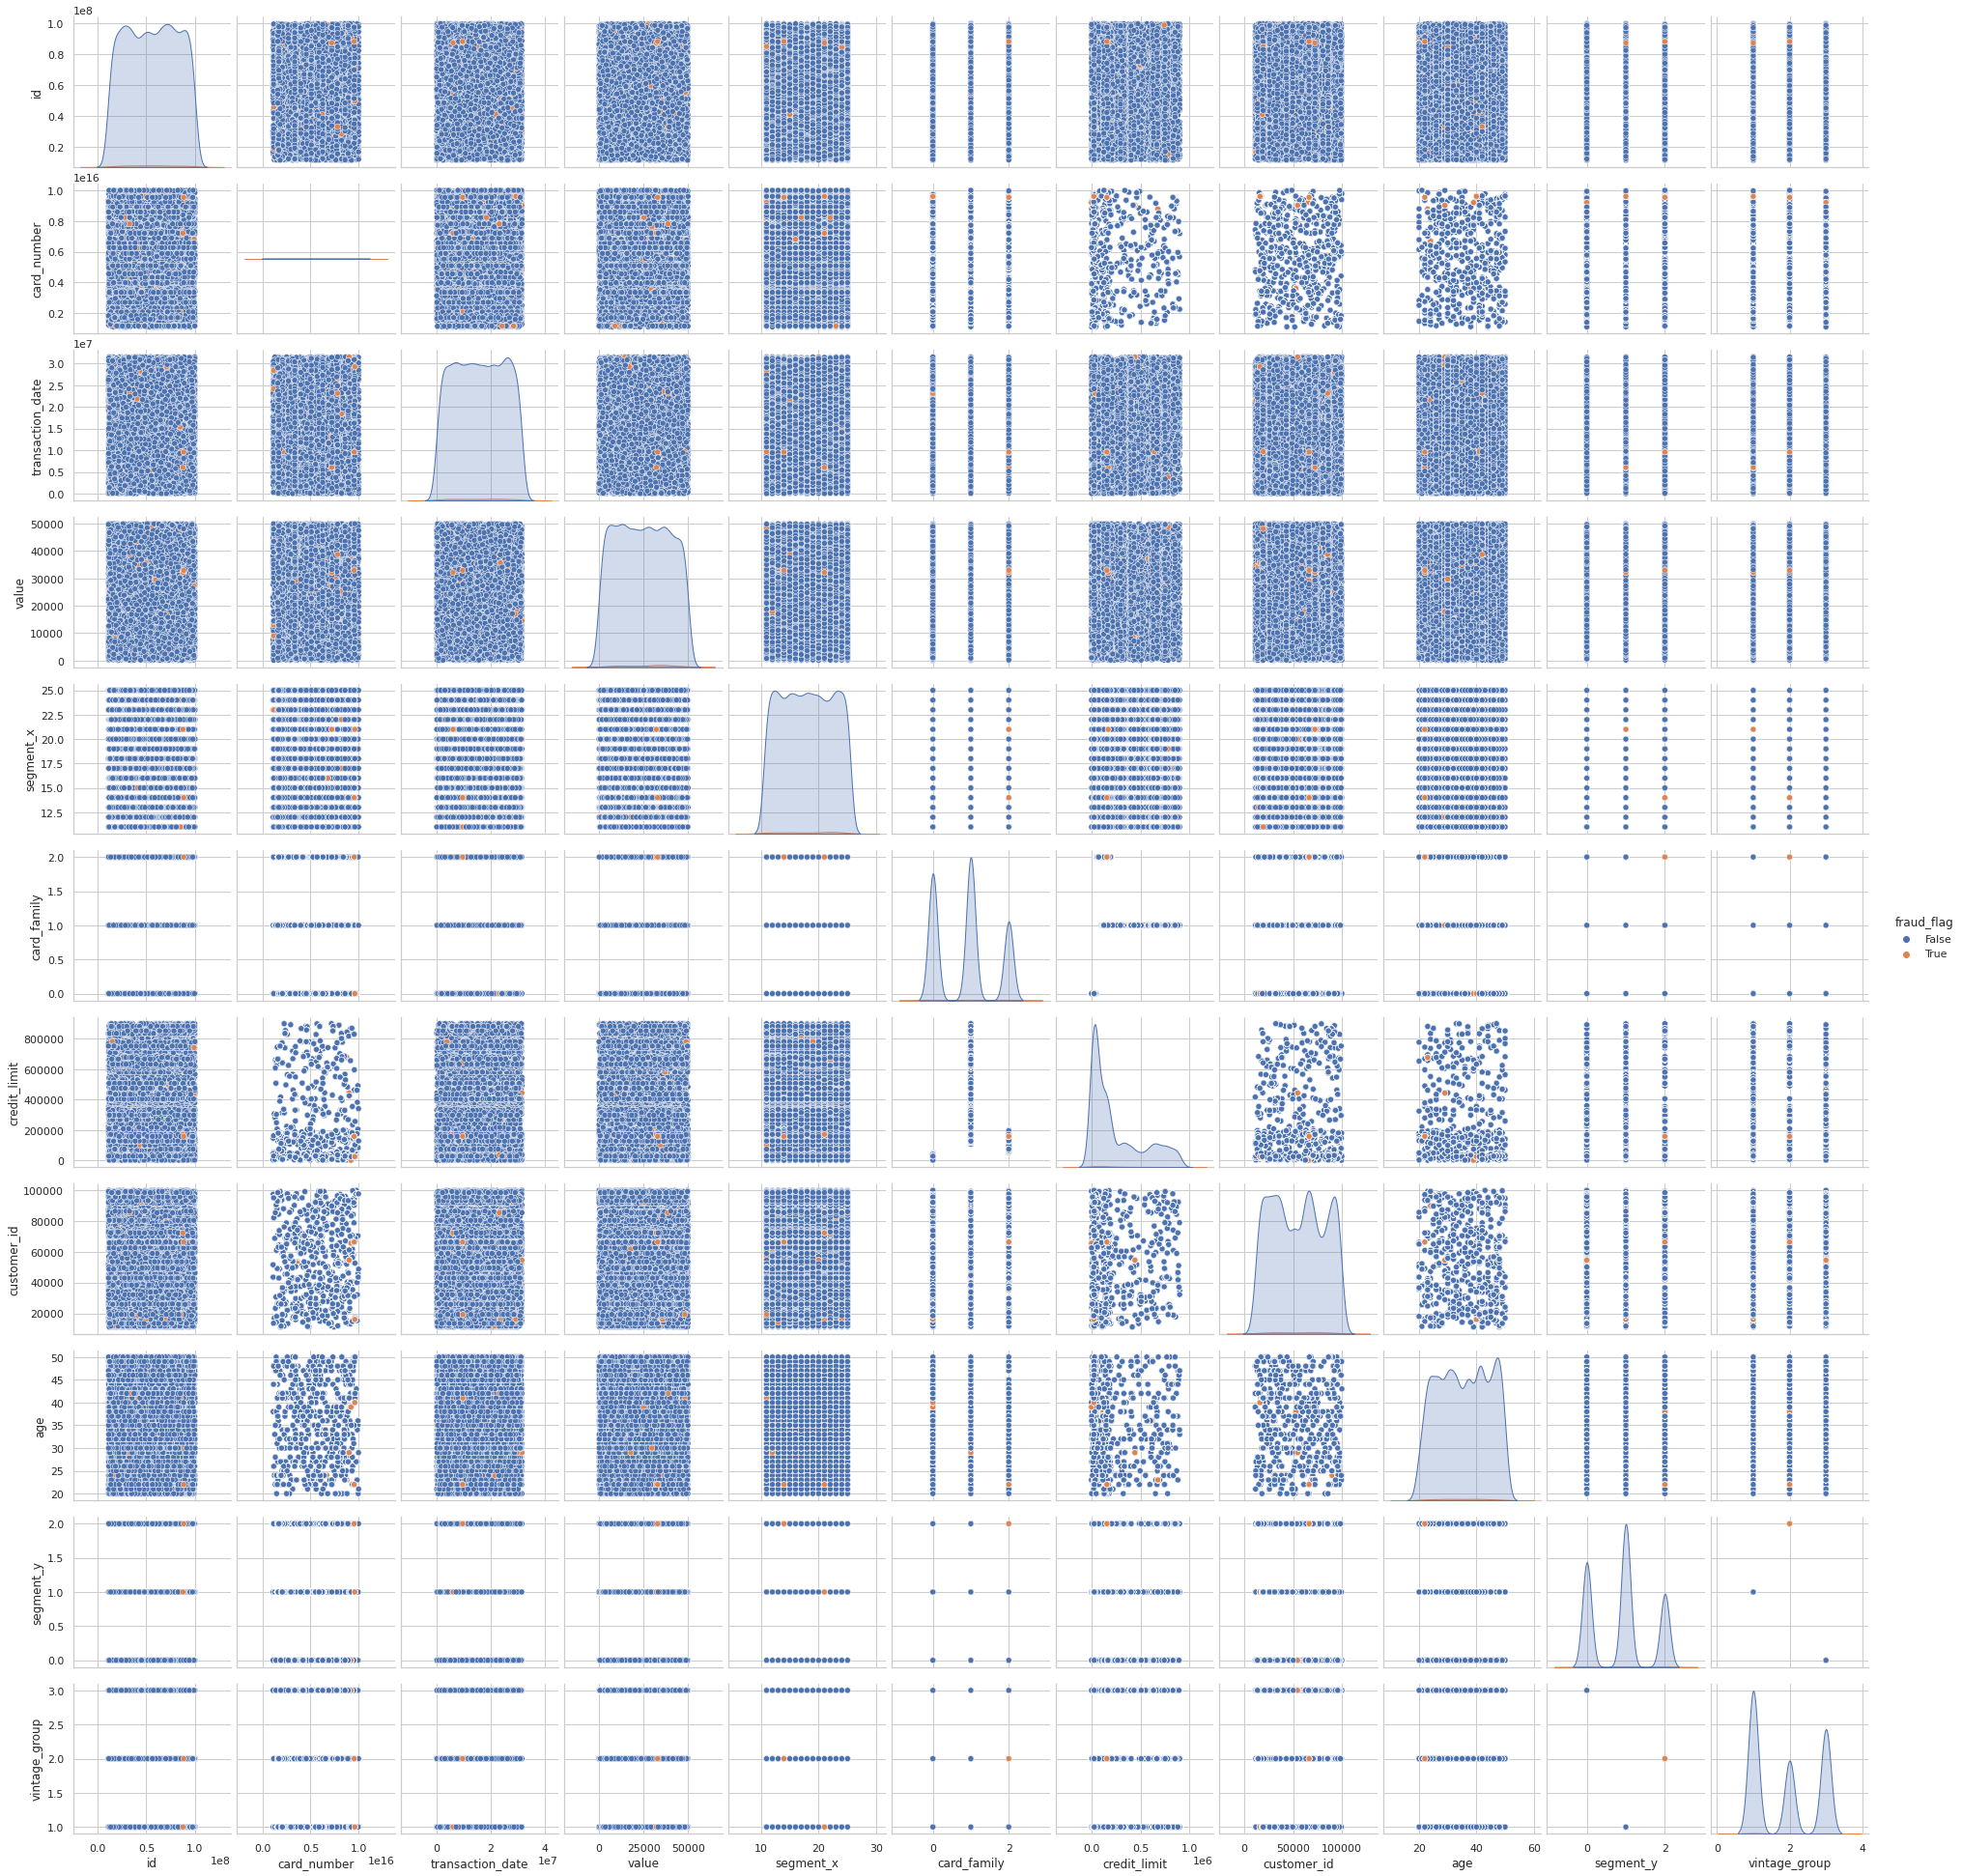

,id,card_number,transaction_date,value,segment_x,card_family,credit_limit,customer_id,age,segment_y,vintage_group,fraud_flag
0,28830551,1629956632852123,9849600.0,23649,25,2,194000,24544,23,0,3,False
1,52843489,1629956632852123,1296000.0,48307,17,2,194000,24544,23,0,3,False
2,54901377,1629956632852123,10108800.0,14032,25,2,194000,24544,23,0,3,False
3,47600881,1629956632852123,16070400.0,11063,24,2,194000,24544,23,0,3,False
4,15312006,1629956632852123,26179200.0,47956,18,2,194000,24544,23,0,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,59593066,9542608296309970,16243200.0,35898,24,2,159000,66351,22,2,2,False
9996,55675834,9542608296309970,3024000.0,46101,25,2,159000,66351,22,2,2,False
9997,22153150,9542608296309970,12700800.0,33263,23,2,159000,66351,22,2,2,False
9998,56275496,9542608296309970,18316800.0,23787,17,2,159000,66351,22,2,2,False


In [217]:
# In this case, using functions is good because python will delete from memory all temporary variables.
def transform_to_numbers(df: dict) -> pandas.DataFrame:
  # Cleans card number to int
  df['card_number'] = df['card_number'].apply(lambda a: int(a.replace('-','')))

  # Transforms date to numerical value in seconds since the first date.
  starting_date = df['transaction_date'].min()
  df['transaction_date'] = df['transaction_date'].apply(lambda a: (a - starting_date).total_seconds())

  # Strips str from numbers
  df['id'] = df['id'].apply(lambda a: int(a.strip('CTID')))
  df['segment_x'] = df['segment_x'].apply(lambda a: int(a.strip('SEG')))
  df['customer_id'] = df['customer_id'].apply(lambda a: int(a.strip('CC')))
  df['vintage_group'] = df['vintage_group'].apply(lambda a: int(a.strip('VG')))
  
  # Translates groups into numbers
  card_family = {"Gold": 0, "Premium": 1, "Platinum": 2}
  df['card_family'] = df['card_family'].apply(lambda label: card_family[label])
  segment_y = {"Diamond": 1, "Gold": 0, "Platinum": 2}
  df['segment_y'] = df['segment_y'].apply(lambda label: segment_y[label])
  return df

def analysis2(data: dict) -> pandas.DataFrame:
  '''Function to pairplot all data. Might take a while to run'''
  
  # Merges all tables
  df1 = data['transactions']
  df2 = pandas.merge(df1, data['cards'], on=['card_number'])
  df3 = pandas.merge(df2, data['customers'].rename(columns={'id':'customer_id'}), on=['customer_id'])

  # Make fraud_flag column to add "False" to transactions not added.
  df3['fraud_flag'] = df3['id'].apply(lambda x: True if x in data['frauds']['transaction_id'].tolist() else False)

  df3 = transform_to_numbers(df3)

  # Pairplots
  seaborn.pairplot(df3, hue="fraud_flag")
  matplotlib.show()
  return df3

all_merged = analysis2(data)
all_merged

As we can see, still not very good. Let's try to look individually to every column:

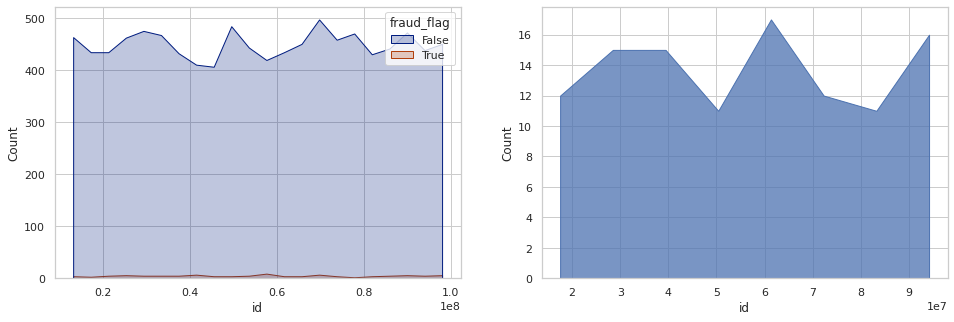

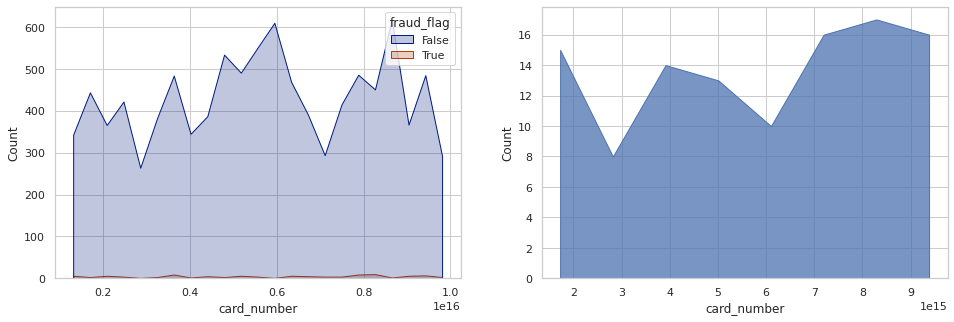

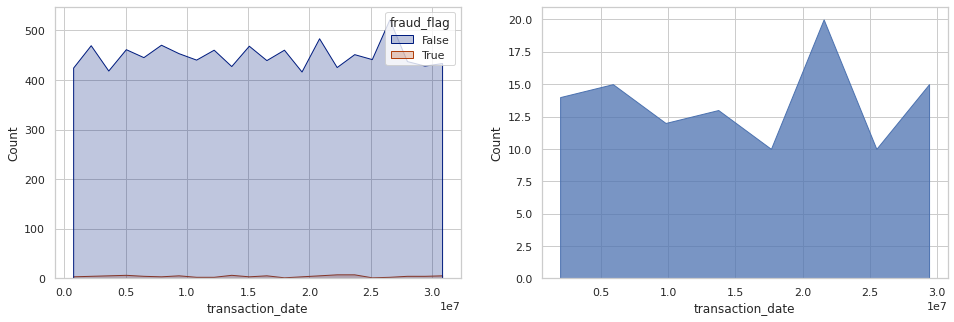

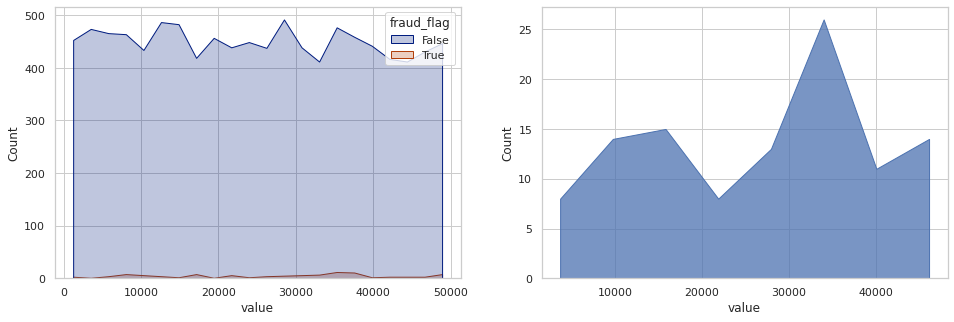

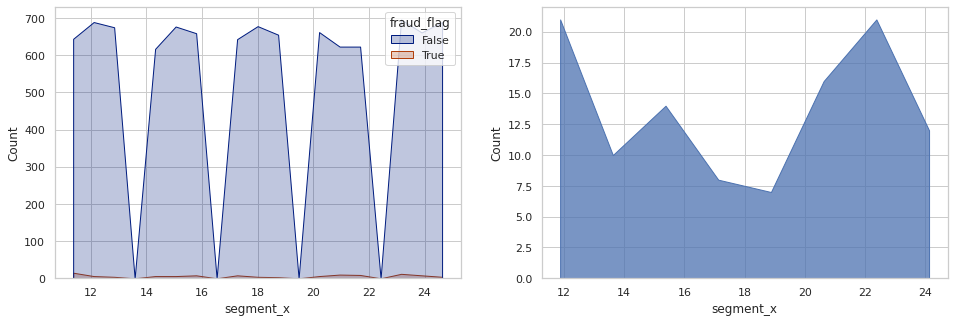

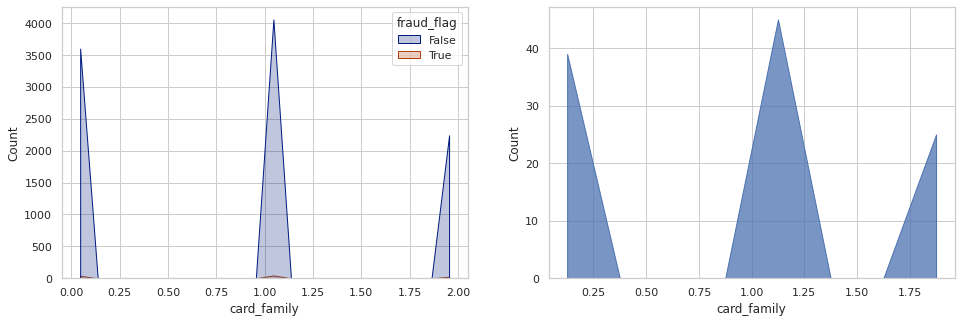

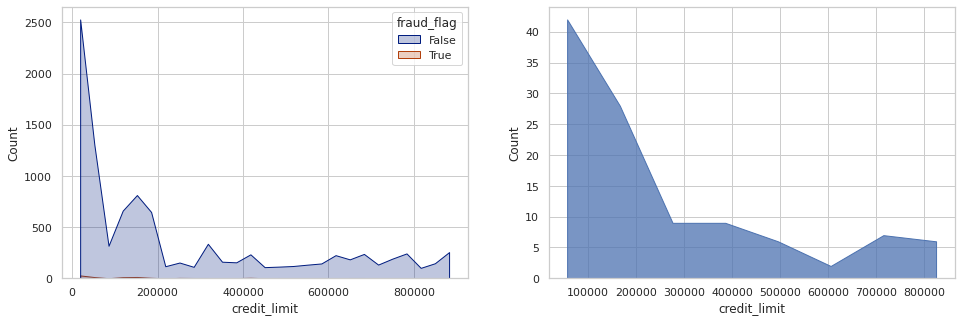

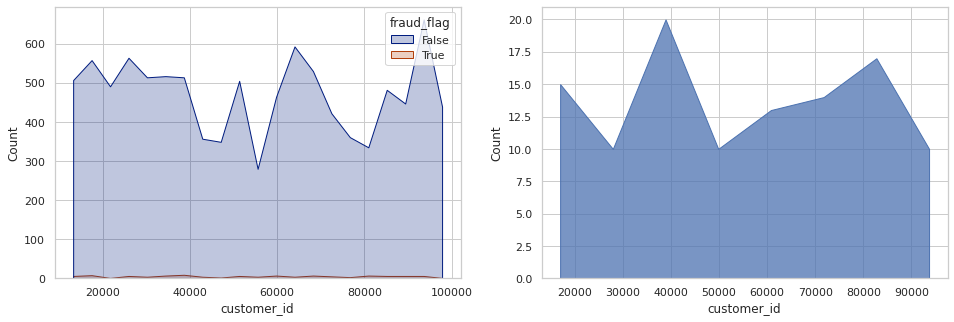

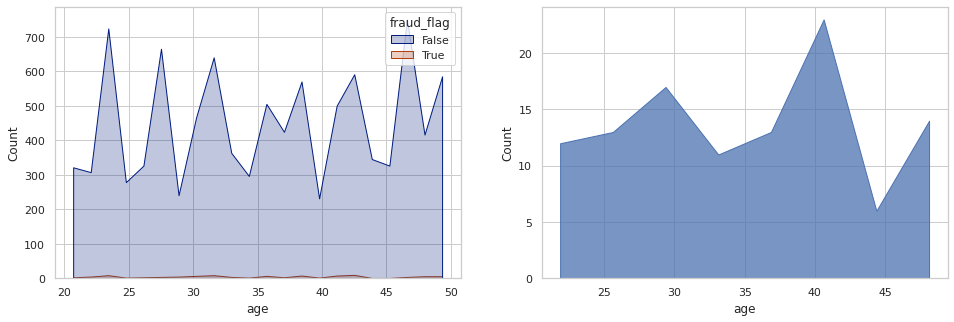

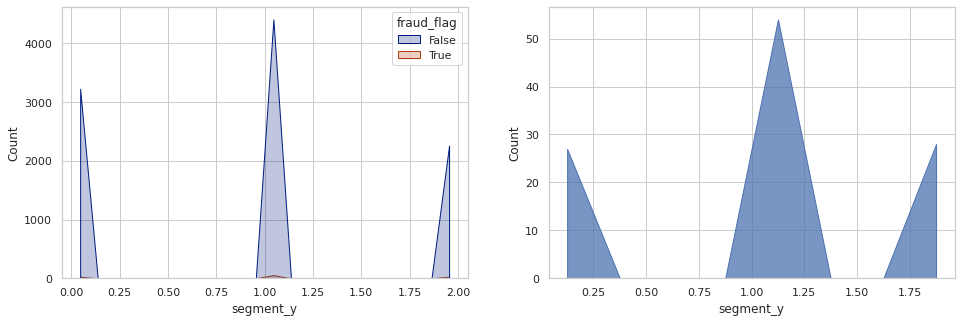

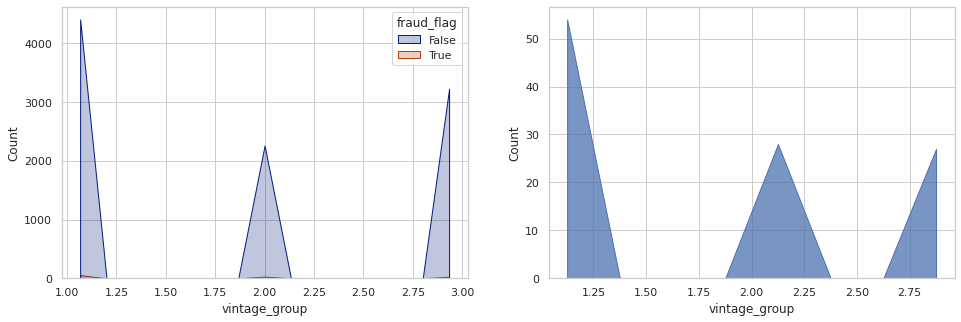

In [221]:
def analysis3(all, fraud):
  '''Final function to analyze our data. Receives all and frauds only'''
  # Cleans str in fraud like we did before
  frauds = transform_to_numbers(fraud.copy())
  # For every column, will print the plot in all and the plot in fraud only.
  for i,column in zip(all.columns,frauds.columns):
    fig, ax = matplotlib.subplots(1,2,figsize=(16,5))
    seaborn.histplot(all, x=column,hue='fraud_flag',palette="dark", element="poly", ax=ax[0])
    seaborn.histplot(frauds, x=column,palette="dark", element="poly", ax=ax[1])
    fig.show()

analysis3(all_merged, frauds_merged)

As we can see, there's no clear indicator to wheter something is a fraud or not, but looking closely at the plots, we can infer that frauds have a different distribution in: age, customer_id, segment_x, value, transaction_date and card_number, that is, frauds usually peak differently than the normal values.

One other interesting thing is how concentrated credit_limit in frauds is, compared to all values. But the difference can be subtle in the macro level.

That's the end of my analysis for now. On an unrelated note, I had tried to make a RandomForestClassifier find the most important features for me, but this failed since both classes are highly disbalanced (I reduced the non-frauds to 109, in a failed attempt to balance it) and there's no clear unique feature that tells us wheter something is a fraud or not.

**This idea is not good because this model is not accurate, but I left the code anyway.**



**Accuracy:** 0.64

**F1 Score:** 0.62

**Recall:** 0.76

Confusion matrix:

[[15 12]
 [ 4 13]]


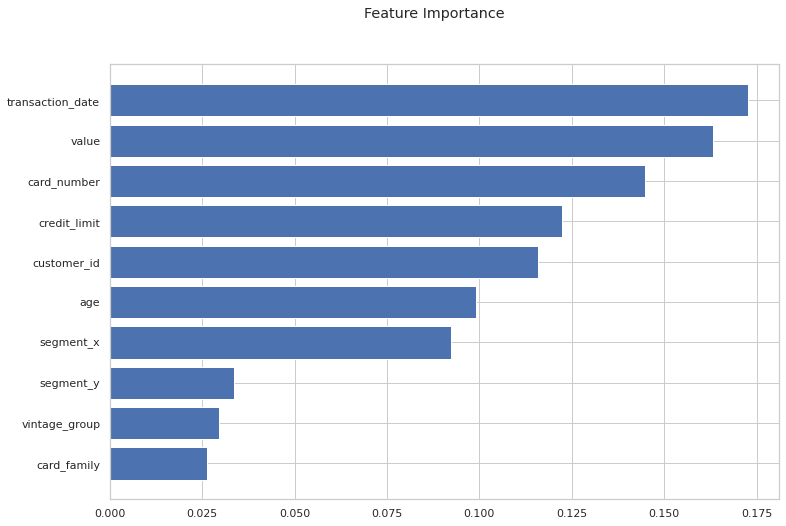

In [250]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split

def analysis4(all: dict):
  '''Function to discover Feature importance using Random Forest'''
  def plot_importances(model,df):
    '''Function to plot importances'''
    importances = model.feature_importances_
    indices = numpy.argsort(importances)
    matplotlib.figure(figsize=(12,8))
    matplotlib.barh(range(len(indices)), importances[indices], color='b', align='center')
    matplotlib.yticks(range(len(indices)), df.columns[indices])
    matplotlib.suptitle('Feature Importance')
    matplotlib.show()

  # Trying to get an enqual number of frauds and not frauds
  nfrauds = all_merged[all_merged['fraud_flag'] == False].sample(n=109)
  frauds = all_merged[all_merged['fraud_flag'] == True]

  # Concatenates, y will be fraud_flag.
  selected = pandas.concat([frauds,nfrauds])
  x = selected.drop(['fraud_flag','id'],axis=1)
  y = selected['fraud_flag']

  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

  model = RandomForestClassifier()
  model.fit(x_train,y_train)

  result = model.predict(x_test)
  # Some scores to test it
  printmd("**Accuracy:** " + str(round(accuracy_score(result, y_test),2)))
  printmd("**F1 Score:** " + str(round(f1_score(result, y_test),2)))
  printmd("**Recall:** " + str(round(recall_score(result, y_test),2)))
  printmd("Confusion matrix:")
  print(confusion_matrix(result, y_test))
  plot_importances(model,x)

analysis4(all_merged)